In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hiteshraa
Your Kaggle Key: ··········


100%|██████████| 5.76G/5.76G [05:19<00:00, 19.4MB/s]



Extracting archive ./cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip to ./cassava-leaf-disease-classification


In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import hashlib

In [3]:
BASE_DIR = "/content/cassava-leaf-disease-classification"

In [4]:
# Load and Inspect Label Map (mapping numerical labels to disease names)
with open(os.path.join(BASE_DIR, "label_num_to_disease_map.json")) as file:
  map_classes = json.loads(file.read())
  map_classes = {int(k): v for k, v in map_classes.items()}

# Display the mapping
print('Class Mapping')
print(json.dumps(map_classes, indent = 4))

Class Mapping
{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [5]:
# Load training image filenames and display the count
input_files = os.listdir(os.path.join(BASE_DIR, "train_images"))
print(f"Number of Training Images: {len(input_files)}")

Number of Training Images: 21397


In [6]:
# Load train.csv and add a human-readable class name based on the mapping
df_train = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
df_train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [7]:
df_train['class_name'] = df_train['label'].map(map_classes)
df_train.head()

image_id  label                           class_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)

In [8]:
df_train['class_name'].value_counts()

class_name
Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: count, dtype: int64

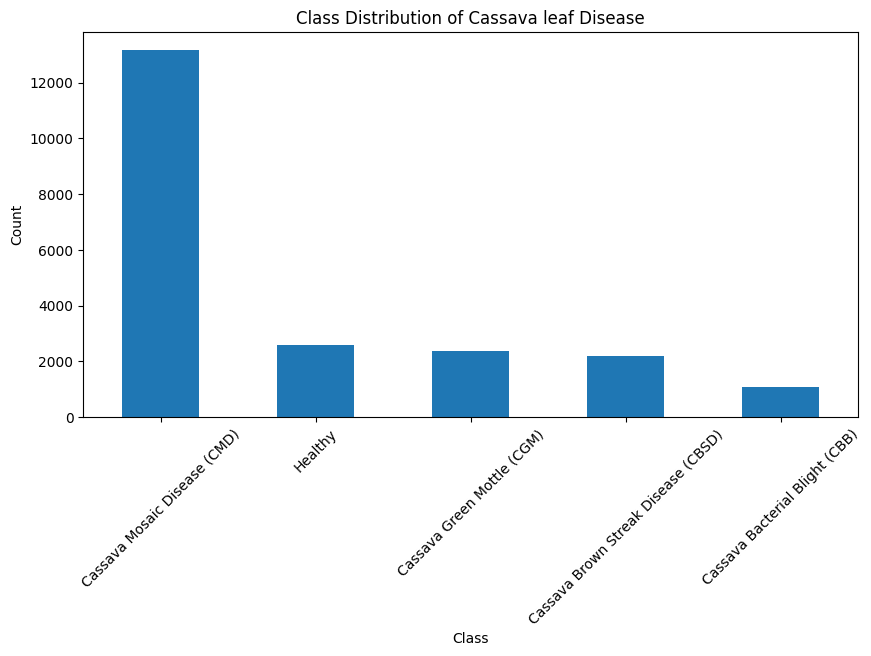

In [9]:
# Check class distribution
class_distribution = df_train['class_name'].value_counts()

# Plot class distribution
plt.figure(figsize = (10, 5))
class_distribution.plot(kind = 'bar')
plt.title('Class Distribution of Cassava leaf Disease')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<ipython-input-10-e8078f8e1b26>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, y='class_name', palette=palette)
<ipython-input-10-e8078f8e1b26>:5: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.countplot(data=df_train, y='class_name', palette=palette)


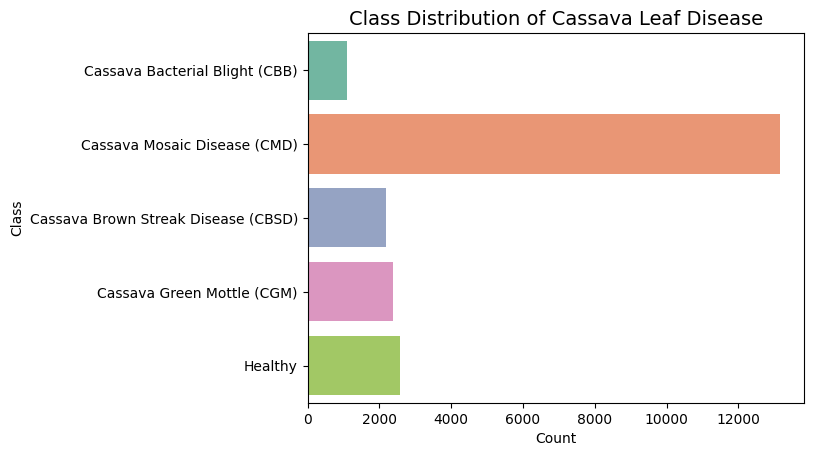

In [10]:
# Set a custom colorful palette
palette = sns.color_palette("Set2")

# Plot the countplot with the custom palette
sns.countplot(data=df_train, y='class_name', palette=palette)

# Add title and labels
plt.title('Class Distribution of Cassava Leaf Disease', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Class')

# Show the plot
plt.show()

In [11]:
# Show data info and summary statistics
print("Dataset Info:")
print(df_train.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    21397 non-null  object
 1   label       21397 non-null  int64 
 2   class_name  21397 non-null  object
dtypes: int64(1), object(2)
memory usage: 501.6+ KB
None


In [12]:
print("\nDataset Summary Statistics:")
print(df_train.describe())


Dataset Summary Statistics:
              label
count  21397.000000
mean       2.651914
std        0.988565
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000


In [13]:
# Check for missing values and duplicates
print(f"\nMissing values in each column:\n{df_train.isnull().sum()}")
print(f"Number of duplicate rows: {df_train.duplicated().sum()}")


Missing values in each column:
image_id      0
label         0
class_name    0
dtype: int64
Number of duplicate rows: 0


In [14]:
# Analyze image shapes (size dimensions) for a sample of 300 images
# Dictionary to store image shapes and their counts
img_shapes = {}
for img_name in os.listdir(os.path.join(BASE_DIR, "train_images"))[:1000]:
  image = cv2.imread(os.path.join(BASE_DIR, "train_images", img_name))
  img_shapes[image.shape] = img_shapes.get(image.shape, 0) + 1

# Display image shapes
print("\nSample Image Shapes and their Frequencies (from 1000 images):")
print(img_shapes)


Sample Image Shapes and their Frequencies (from 1000 images):
{(600, 800, 3): 1000}


In [15]:
# Function to plot sample images from a specific class
def plot_images_from_class(class_id, num_images = 9):
    """
    Plot sample images from a specific class in a 3x3 grid.

    Parameters:
        class_id (int): The class label to filter images.
        num_images (int): The number of images to plot.
    """
    # Filter images for the specified class
    class_images = df_train[df_train['label'] == class_id]
    num_images = min(len(class_images), num_images)

    plt.figure(figsize = (15, 15))
    images = class_images.sample(num_images)

    # Plot images in a 3x3 grid
    for i, (_, row) in enumerate(images.iterrows()):
      img_path = os.path.join(BASE_DIR, "train_images", row['image_id'])
      img = Image.open(img_path)
      plt.subplot(3, 3, i + 1)
      plt.imshow(img)
      plt.title(map_classes[class_id])
      plt.axis('off')

    plt.tight_layout()
    plt.show()


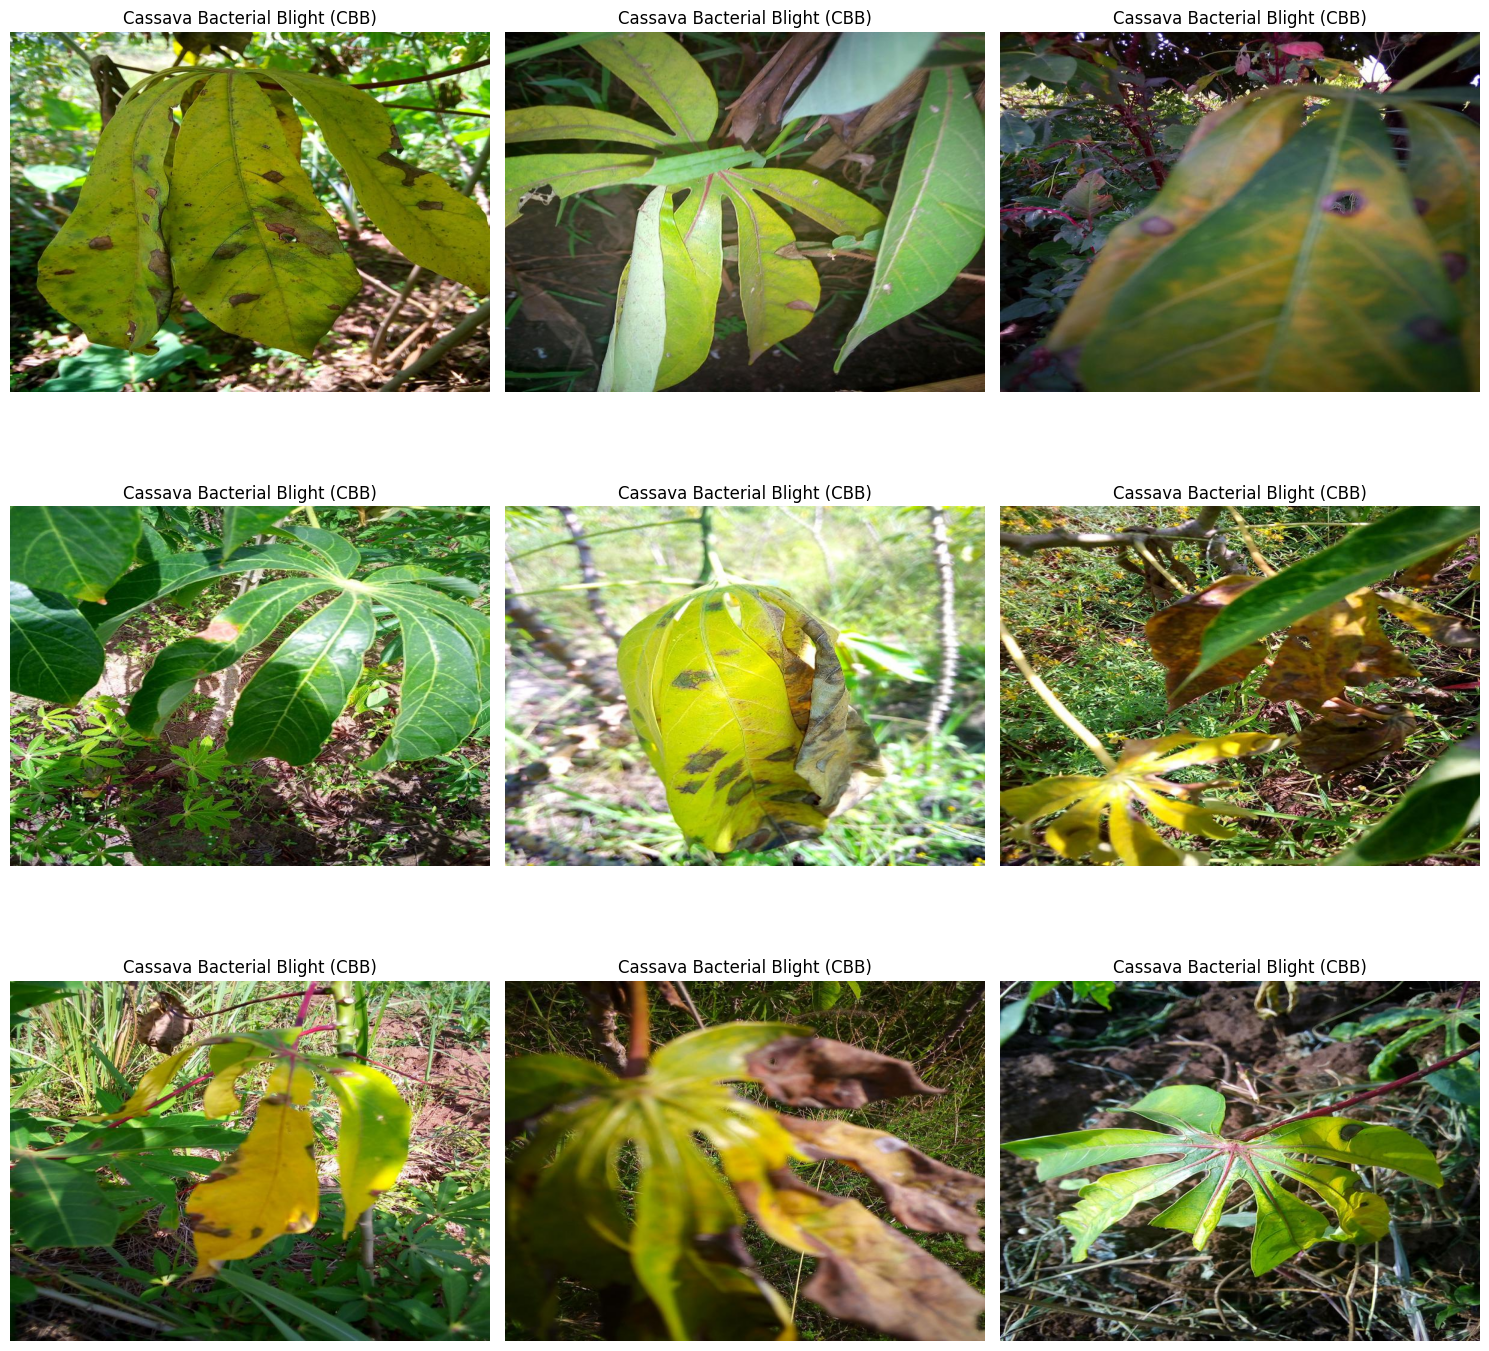

In [16]:
plot_images_from_class(0)

In [17]:
# for i in range(5):
#   print(f"Displaying sample images of class: {map_classes[i]}")
#   plot_images_from_class(i)

In [18]:
# Check image shapes for the entire dataset
df_train['Image_shape'] = df_train['image_id'].apply(lambda x: cv2.imread(os.path.join(BASE_DIR, "train_images", x)).shape)

In [19]:
# Group by class and image shape to see if there's a pattern in image size by disease type
shape_class_dict = df_train.groupby(['class_name', 'Image_shape']).size().unstack(fill_value = 0)

Text(0, 0.5, 'Values')

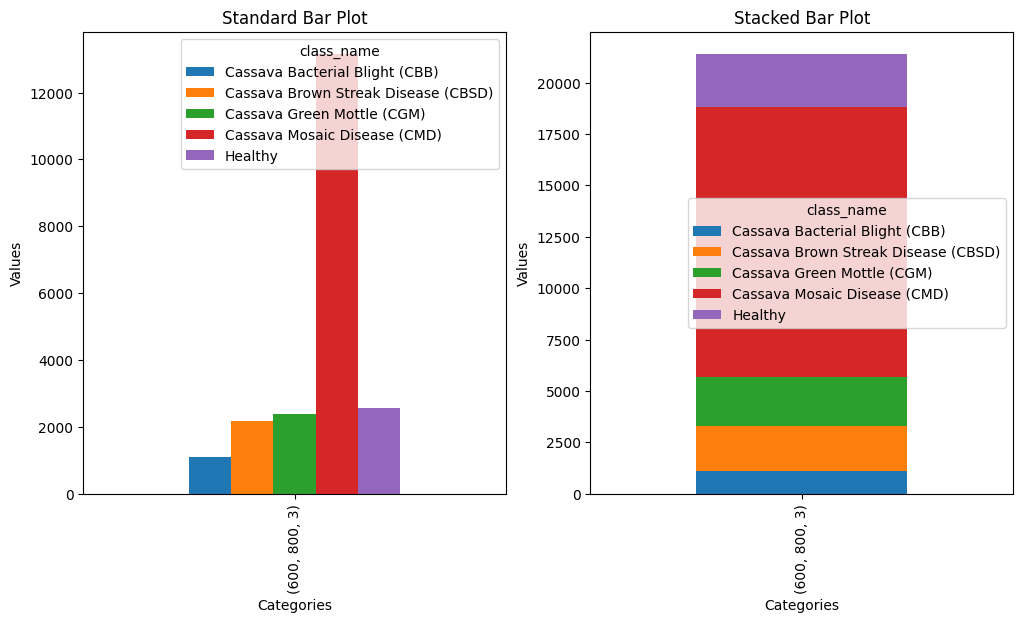

In [20]:
# Plot the distribution of image sizes for each class
plt.figure(figsize=(12, 6))
# First subplot: standard bar plot
plt.subplot(1, 2, 1)
shape_class_dict.T.plot(kind='bar', ax=plt.gca())  # Use current axis
plt.title('Standard Bar Plot')
plt.xlabel('Categories')
plt.ylabel('Values')

# Second subplot: stacked bar plot
plt.subplot(1, 2, 2)
shape_class_dict.T.plot(kind='bar', stacked=True, ax=plt.gca())  # Use current axis
plt.title('Stacked Bar Plot')
plt.xlabel('Categories')
plt.ylabel('Values')

In [21]:
df_train.head()

image_id  label                           class_name    Image_shape
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)  (600, 800, 3)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)  (600, 800, 3)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)  (600, 800, 3)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)  (600, 800, 3)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)  (600, 800, 3)

In [22]:
df_train['label_names'] = df_train['label'].map(map_classes)

####**Duplicate Images**

In [23]:
# Finding Duplicate Images
# Identifying Exact Duplicate Images

def get_image_hash(image_path):
  """Generate an MD5 hash for the image."""
  with open(image_path, 'rb') as f:
    file_hash = hashlib.md5(f.read()).hexdigest()
  return file_hash

In [24]:
# Initialize dictionary to store hashes
images_hash = {}

# List to store duplicate image pairs
duplicate_image = []

# Iterate over all images in the directory
for image_name in os.listdir(os.path.join(BASE_DIR, "train_images")):
    image_path = os.path.join(BASE_DIR, "train_images", image_name)
    image_hash = get_image_hash(image_path)

    if image_hash in images_hash:
        duplicate_image.append((image_name, images_hash[image_hash]))  # Image is a duplicate
    else:
        images_hash[image_hash] = image_name  # Store the hash and image name

# Output the results
print(f"Found {len(duplicate_image)} exact duplicate images.")
for dup in duplicate_image:
    print(f"Duplicate pair: {dup[0]} and {dup[1]}")

Found 0 exact duplicate images.


In [25]:
len(images_hash)

21397

###**Model 1: Base Model**

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model architecture
model = models.Sequential()

# 1st Convolutional block
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolutional block
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolutional block
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# 4th Convolutional block
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed it into fully connected layers
model.add(layers.Flatten())

# Dense layer with 512 units
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output layer for classification (assuming 5 classes)
model.add(layers.Dense(5, activation = 'softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,393,573 (9.13 MB)

 Trainable params: 2,392,293 (9.13 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [28]:
# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [29]:
image_dir = "/content/cassava-leaf-disease-classification/train_images"

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator to preprocess images
datagen = ImageDataGenerator(rescale = 1./255,
                             validation_split = 0.2) # Normalize pixel values

# Generate training and validation datasets
train_dataset = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = image_dir,
    x_col = 'image_id', # Assuming image path column is named "image_path",
    y_col = "class_name",
    target_size = (224, 224), # Adjust the image size
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

val_dataset = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = image_dir,
    x_col = 'image_id',
    y_col = 'class_name',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = False
)

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [31]:
# Train the model
history = model.fit(train_dataset,
          validation_data= val_dataset,
          epochs = 10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


535/535 ━━━━━━━━━━━━━━━━━━━━ 140s 241ms/step - accuracy: 0.4805 - loss: 1.6746 - val_accuracy: 0.5424 - val_loss: 1.2644
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 99s 183ms/step - accuracy: 0.6362 - loss: 1.0076 - val_accuracy: 0.6780 - val_loss: 0.8456
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 145s 187ms/step - accuracy: 0.6751 - loss: 0.8599 - val_accuracy: 0.6885 - val_loss: 0.8217
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 139s 182ms/step - accuracy: 0.7003 - loss: 0.7952 - val_accuracy: 0.6296 - val_loss: 0.8718
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 103s 190ms/step - accuracy: 0.7300 - loss: 0.7176 - val_accuracy: 0.6983 - val_loss: 0.7940
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 135s 178ms/step - accuracy: 0.7428 - loss: 0.6791 - val_accuracy: 0.6679 - val_loss: 0.9318
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 102s 189ms/step - accuracy: 0.7768 - loss: 0.5965 - val_accuracy: 0.6653 - val_loss: 1.0507
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 138s 182ms/step - accuracy: 0.8004 - loss: 0.540

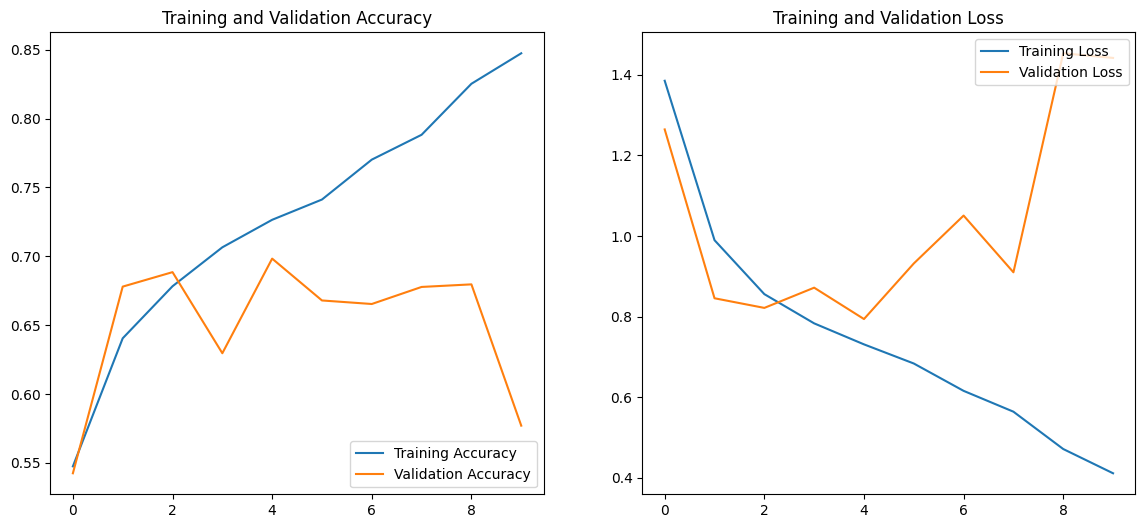

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

##**Transfer Learning**

###**Visualizing the augmentations**

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# Example usage on one image
from tensorflow.keras.preprocessing import image

img = image.load_img("/content/cassava-leaf-disease-classification/train_images/1003888281.jpg", target_size = (224, 224))
x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)

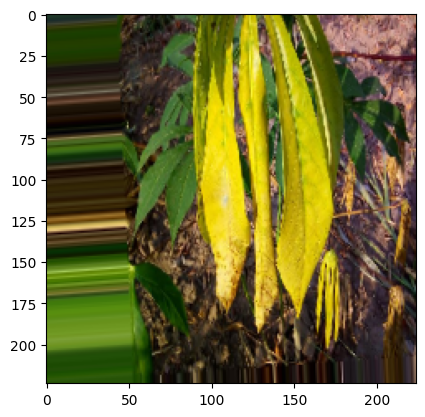

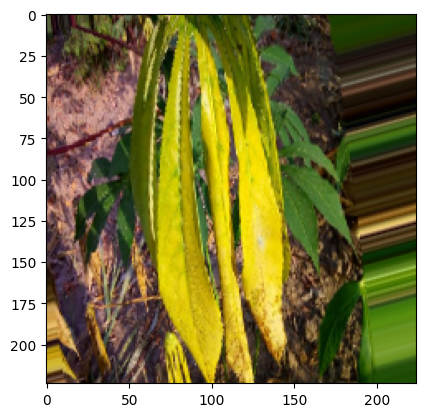

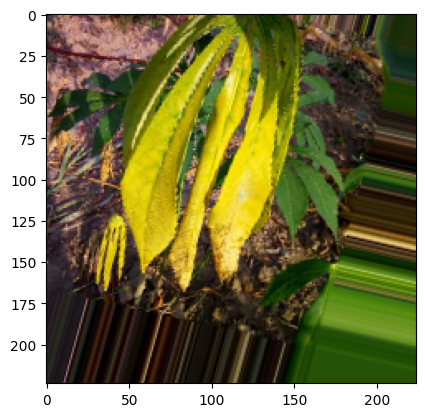

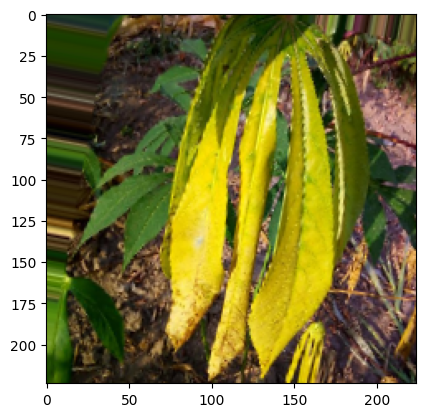

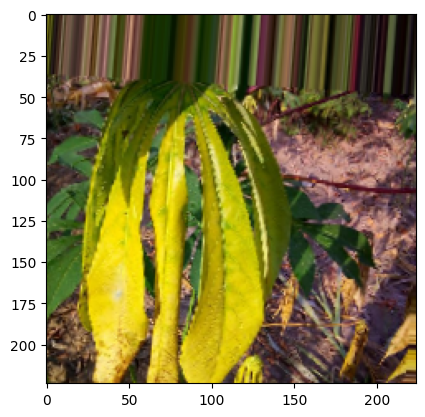

In [34]:
# Generating 5 augmentated images
i = 0
for batch in datagen.flow(x, batch_size = 1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break
plt.show()

##**Transfer Learning**

- ## **ResNet**

In [35]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model without the top classification layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [36]:
# Freeze the base model
base_model.trainable = False

In [37]:
# Create a new model on top
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(5, activation = 'softmax')
])

In [38]:
# Paths
work_dir = "/content/cassava-leaf-disease-classification"
train_path = os.path.join(work_dir, "train_images")
train_csv_path = os.path.join(work_dir, 'train.csv')
label_map_path = os.path.join(work_dir, 'label_num_to_disease_map.json')

In [39]:
# Load Train data
data = pd.read_csv(train_csv_path)
print("Initial DataFrame: ")
print(data.head())

# Check label frequencies
print("\nLabel Frequencies:")
print(dict(data['label'].value_counts()))

Initial DataFrame: 
         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

Label Frequencies:
{3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087}


In [40]:
# Load Label Mapping
with open(label_map_path, 'r') as file:
  real_labels = json.load(file)

# Convert string keys to integers
real_labels = {int(k): v for k, v in real_labels.items()}

# Map label numbers to class names
data['class_names'] = data['label'].map(real_labels)
print("\nDataFrame with Class Names:")
print(data.head())


DataFrame with Class Names:
         image_id  label                          class_names
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)


In [41]:
from sklearn.utils import class_weight

# Compute Class Weights
labels = data['label'].values

# Compute Class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(labels),
    y = labels
)

In [42]:
# Create a dictionary mapping class indices to weights
class_weight_dict = {i: weight for i, weight in enumerate(class_weights_array)}
print("\nClass Weights:")
print(class_weight_dict)


Class Weights:
{0: 3.9368905243790246, 1: 1.954956601187757, 2: 1.7935456831517183, 3: 0.3252317981456148, 4: 1.6606131160263873}


In [43]:
# Define ImageDataGenerators
IMG_SIZE = 224
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)
NUM_CLASSES = 5
BATCH_SIZE = 32

In [44]:
import tensorflow as tf

datagen_train = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

In [45]:
# ImageDataGenerator for validation (only normalization)

datagen_val = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input
)

In [46]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(data, test_size = 0.2, random_state = 42, stratify = data['class_names'])

In [47]:
print(f"\nNumber of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(val_df)}")


Number of training samples: 17117
Number of validation samples: 4280


In [48]:
train_set = datagen_train.flow_from_dataframe(
    train_df,
    directory = train_path,
    x_col = 'image_id',
    y_col = 'class_names',
    target_size = TARGET_SIZE,
    class_mode = 'categorical',
    interpolation = 'nearest',
    shuffle = True,
    batch_size = BATCH_SIZE
)

val_set = datagen_val.flow_from_dataframe(
    val_df,
    directory = train_path,
    x_col = 'image_id',
    y_col = 'class_names',
    target_size = TARGET_SIZE,
    class_mode = 'categorical',
    interpolation = 'nearest',
    shuffle = True,
    batch_size = BATCH_SIZE
)

Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


In [49]:
base_model = ResNet50(input_shape = (224, 224, 3), include_top = False,
                      weights = 'imagenet')

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50

# Set up the model
model = Sequential()

# Add an Input Layer
model.add(tf.keras.Input(shape = (224, 224, 3)))

# Add ResNet50 base model
base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
model.add(base_model)

In [51]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50

def create_model():

  model = Sequential()
  # Add an Input layer
  model.add(tf.keras.Input(shape = (224, 224, 3)))

  # Initialize EfficientNetB3 with input_shape explicitly defined
  base_model = ResNet50(input_shape=(224, 224, 3), include_top=False,
                                weights='imagenet')

  # Freeze layers (Except last 40 layers)
  for layer in base_model.layers[:-40]:
    layer.trainable = False

  # Add the base model
  model.add(base_model)

  # Add Global Average Pooling layer
  model.add(GlobalAveragePooling2D())

  # Add Dense Layer with Regularization
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.5))

  # Add output Dense layer for classification (5 classes)
  model.add(Dense(5, activation = 'softmax'))

  return model

In [53]:
# Create and summarize the model
model = create_model()

In [54]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 16,357,637 (62.40 MB)

 Non-trainable params: 7,755,904 (29.59 MB)

In [55]:
EPOCHS = 20
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def model_fit():
  model = create_model()

  # Compile the model
  model.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

  # Stop training when the val_loss has stopped decreasing for 3 epochs.
  es = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                      restore_best_weights=True, verbose=1)

  # Save the model with the minimum validation loss
  checkpoint_cb = ModelCheckpoint("Cassava_best_model.keras",
                                  save_best_only=True,
                                  monitor = 'val_loss',
                                  mode='min')
  # reduce learning rate
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                factor = 0.2,
                                patience = 2,
                                min_lr = 1e-6,
                                mode = 'min',
                                verbose = 1)

  history = model.fit(train_set,
                      validation_data = val_set,
                      epochs = EPOCHS,
                      batch_size = BATCH_SIZE,
                      steps_per_epoch = STEP_SIZE_TRAIN,
                      validation_steps = STEP_SIZE_VALID,
                      callbacks = [es, checkpoint_cb, reduce_lr])

  model.save('Cassava_Model'+'.keras')

  return history


In [57]:
trained_model, results = model_fit()

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


534/534 ━━━━━━━━━━━━━━━━━━━━ 342s 585ms/step - accuracy: 0.6641 - loss: 1.0271 - val_accuracy: 0.7415 - val_loss: 1.1578 - learning_rate: 0.0010
Epoch 2/20
  1/534 ━━━━━━━━━━━━━━━━━━━━ 1:46 200ms/step - accuracy: 0.8438 - loss: 0.5788

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


534/534 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8438 - loss: 0.5788 - val_accuracy: 0.9583 - val_loss: 0.2037 - learning_rate: 0.0010
Epoch 3/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 340s 543ms/step - accuracy: 0.7626 - loss: 0.6657 - val_accuracy: 0.7829 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 4/20
  1/534 ━━━━━━━━━━━━━━━━━━━━ 1:19 149ms/step - accuracy: 0.7812 - loss: 0.5477
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - accuracy: 0.7812 - loss: 0.5477 - val_accuracy: 0.7500 - val_loss: 0.6510 - learning_rate: 0.0010
Epoch 5/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 321s 543ms/step - accuracy: 0.7905 - loss: 0.5777 - val_accuracy: 0.7730 - val_loss: 0.6601 - learning_rate: 2.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


TypeError: cannot unpack non-iterable History object

In [ ]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
map_classes

In [ ]:
class_labels = ['Cassava Bacterial Blight (CBB)',
                'Cassava Brown Streak Disease (CBSD)',
                'Cassava Green Mottle (CGM)',
                'Healthy']

In [ ]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

def predict_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    return predicted_class_index, predictions[0][predicted_class_index]

In [ ]:
# Example usage of predict_image
img_path = '/content/cassava-leaf-disease-classification/train_images/1003888281.jpg'  # Replace with your image path
predicted_index, confidence = predict_image(trained_model, img_path)
print(f"Predicted Class Index: {predicted_index}, Confidence: {confidence:.2f}")